In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import cftime
from glob import glob
import cmocean

# Parameters for the alkalinity budget
o2_2_nh4 = 118/16;
alk_2_n_denit = 552/472
alk_2_nh4_amx = 2.0/5.0
n_2_n_denit = 472/(5*16)
o2_2_nitrif = 2
seconds_per_year = 24*60*60*365

## Generate paths

In [2]:
# pp path
pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20241211/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'
#pp_path = '/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b06_piC_khtr600_khth600/gfdl.ncrc5-intel23-prod-openmp/pp/'


In [3]:
grid_file = pp_path + 'ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [4]:
# alk vertical integral 
diag_type = 'ocean_cobalt_tracers_instant'
variable = 'wc_vert_int_alk'

total_vertint_files = glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + variable + '.nc')
#print(total_vertint_files)

In [5]:
# fluxes
diag_type = 'ocean_cobalt_fluxes_int'
variables = ['wc_vert_int_jdiss_cadet','wc_vert_int_jprod_cadet',
             'wc_vert_int_juptake_no3','wc_vert_int_juptake_nh4',
             'wc_vert_int_jprod_no3nitrif',#'wc_vert_int_jnitrif',
             'wc_vert_int_nfix','wc_vert_int_jno3denit',
             'wc_vert_int_jo2resp','wc_vert_int_jnamx']

flux_vertint_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
flux_vertint_files = sorted([f for fi in flux_vertint_files for f in fi]) # nested list comprehension

In [6]:
# nitrogen/alkalinity budget files
# surface fluxes
diag_type = 'ocean_cobalt_sfc'
variables = ['runoff_flux_alk','runoff_flux_ldon','runoff_flux_sldon','runoff_flux_srdon',
             'dep_dry_nh4','dep_wet_nh4','nh4_stf_gas']

surf_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
surf_files = sorted([f for fi in surf_files for f in fi]) # nested list comprehension
#print(surf_files)

In [7]:
# nitrogen budget files
# bottom fluxes
diag_type = 'ocean_cobalt_btm'
variables = ['fnoxic_sed','fno3denit_sed','fndet_burial','fn_burial',
             'cased','fcased_redis','fcadet_arag_btm','fnfeso4red_sed']

btm_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
btm_files = sorted([f for fi in btm_files for f in fi]) # nested list comprehension

## Read in files

In [8]:
total = xr.open_mfdataset(total_vertint_files, combine='by_coords')

In [9]:
flux = xr.open_mfdataset(flux_vertint_files, combine='by_coords')

In [10]:
surf = xr.open_mfdataset(surf_files, combine='by_coords')

In [11]:
btm = xr.open_mfdataset(btm_files, combine='by_coords')

## Compute Global Inventory

These values are from ocean_cobalt_tracer_instant and are written out at the end of the year

In [12]:
total.wc_vert_int_alk

<xarray.DataArray 'wc_vert_int_alk' (time: 40, yh: 1161, xh: 1440)> Size: 267MB
dask.array<concatenate, shape=(40, 1161, 1440), dtype=float32, chunksize=(5, 1161, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 320B 0002-01-01 00:00:00 ... 0041-01-01 00:00:00
  * xh       (xh) float64 12kB -299.9 -299.6 -299.4 -299.1 ... 59.38 59.62 59.88
  * yh       (yh) float64 9kB -88.52 -88.42 -88.32 -88.23 ... 89.73 89.84 89.95
Attributes:
    units:          mol m-2
    long_name:      Total alkalinity vertical integral
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello

In [13]:
global_total = (total.wc_vert_int_alk * grid.areacello).sum(dim=['xh','yh'])
global_total = global_total

Text(0.5, 1.0, 'Global alk inventory (Emol)')

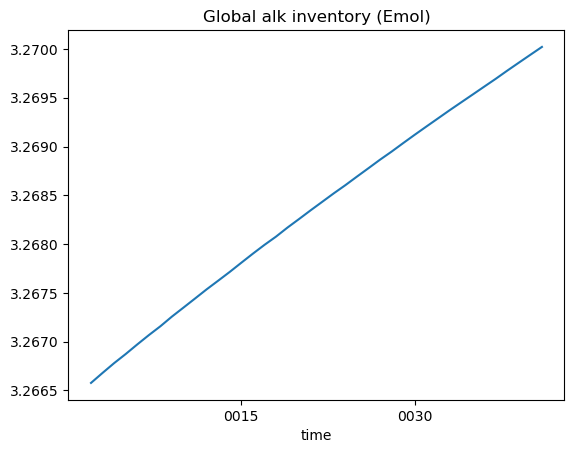

In [14]:
(global_total/1e18).plot()
#plt.ylim(37.94,37.948)
plt.title('Global alk inventory (Emol)')

## Compute Fluxes

In [15]:
# phytoplankton production via nitrate increases alkalinity by 1 unit per mole
npp_no3 = (flux.wc_vert_int_juptake_no3 * grid.areacello).sum(dim=['xh','yh'])
npp_no3 = npp_no3 * 1 * seconds_per_year

In [16]:
# phytoplankton production via nitrate decreases alkalinity by 1 unit per mole
npp_nh4 = (flux.wc_vert_int_juptake_nh4 * grid.areacello).sum(dim=['xh','yh'])
npp_nh4 = npp_nh4 * -1 * seconds_per_year

In [17]:
# # # phytoplankton production via nitrogen fixation - no net change 
# # Net change in alkalinity from nitrogen fixation; fixation of N2 leads to
# # no change in alkalinity, but eventual remineralization (+1) and
# # nitrification (-2) leads to a net alkalinity decrease of 1 unit
# npp_nfix = (flux.wc_vert_int_nfix * grid.areacello).sum(dim=['xh','yh'])
# npp_nfix = npp_nfix * -1 * seconds_per_year

In [18]:
# dissolution of calcite and aragonite detritus increases alkalinity by 2 units per mole dissolved
diss_cadet = (flux.wc_vert_int_jdiss_cadet * grid.areacello).sum(dim=['xh','yh'])
diss_cadet = diss_cadet * 2 * seconds_per_year

In [19]:
# production of calcite and aragonite decreases alkalinity by 2 units per mole
prod_cadet = (flux.wc_vert_int_jprod_cadet * grid.areacello).sum(dim=['xh','yh'])
prod_cadet = prod_cadet * -2 * seconds_per_year

In [20]:
# nitrification decreases alkalinity by 2 units
nitrif = (flux.wc_vert_int_jprod_no3nitrif * grid.areacello).sum(dim=['xh','yh'])
nitrif = nitrif * -2 * seconds_per_year

In [21]:
# denitrification increases alkalinity by alk_2_n_denit units
denitrif = (flux.wc_vert_int_jno3denit * grid.areacello).sum(dim=['xh','yh'])
denitrif = denitrif * alk_2_n_denit * seconds_per_year

In [22]:
# anammox increases alkalinity by alk_2_nh4_amx units (2/5)
amx = (flux.wc_vert_int_jnamx * grid.areacello).sum(dim=['xh','yh'])
amx = amx * alk_2_nh4_amx * seconds_per_year

In [23]:
# remineralization increases alkalinity by 1 unit
# (cobalt%jo2resp_wc(i,j,k)-cobalt%juptake_nh4nitrif(i,j,k)*cobalt%o2_2_nitrif)/cobalt%o2_2_nh4
nitrif_remin = (flux.wc_vert_int_jprod_no3nitrif * grid.areacello).sum(dim=['xh','yh'])
remin = (flux.wc_vert_int_jo2resp * grid.areacello).sum(dim=['xh','yh'])

remin = (remin - (nitrif_remin / o2_2_nitrif)) / o2_2_nh4
remin = remin * seconds_per_year

In [24]:
runoff = (surf.runoff_flux_alk * grid.areacello).sum(dim=['xh','yh'])
runoff = runoff * seconds_per_year

In [25]:
# runoff adds partially reduced nitrogen to the system.  
# This is remineralized (+1) and subsequently nitrified (-2).  
# The net effect of organic nitrogen addition is thus an alkalinity sink.
    
don_runoff = surf.runoff_flux_ldon + surf.runoff_flux_sldon + surf.runoff_flux_srdon
don_runoff = (don_runoff * grid.areacello).sum(dim=['xh','yh'])
don_runoff = don_runoff * -1 * seconds_per_year

In [26]:
total_runoff = runoff + don_runoff

In [27]:
# Additions and subtractions of ammonia remove reduced nitrogen.  Addition
# and subsequent nitrification decreases alkalinity by 2 units - alkalinity sink.

total_deposition = surf.dep_dry_nh4 + surf.dep_wet_nh4 + surf.nh4_stf_gas

total_deposition = (total_deposition * grid.areacello).sum(dim=['xh','yh'])
total_deposition = total_deposition * -2 * seconds_per_year

In [28]:
# sediment processes 

# aerobic remin
sed_remin = (btm.fnoxic_sed * grid.areacello).sum(dim=['xh','yh']) * seconds_per_year # already in N units - do not need to convert from O2 to N

# denitrification
sed_denit = (btm.fno3denit_sed * grid.areacello).sum(dim=['xh','yh']) * alk_2_n_denit * seconds_per_year

# calcite dissolution
sed_diss_cadet = ((btm.fcadet_arag_btm + btm.fcased_redis) * grid.areacello).sum(dim=['xh','yh']) * 2 * seconds_per_year

Text(0.5, 1.0, 'Net alkalinity fluxes (g C equivalent)')

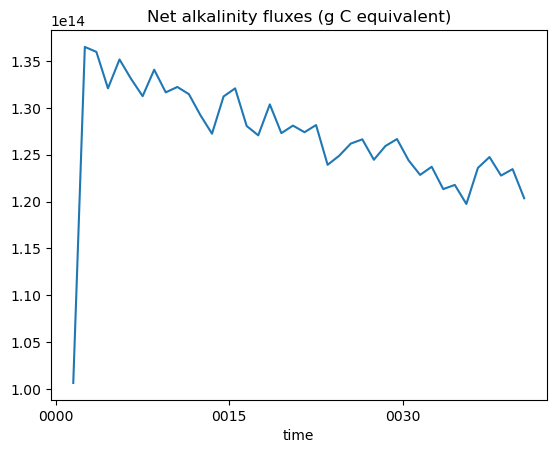

In [29]:
net_flux = (npp_no3 + npp_nh4) + prod_cadet + (diss_cadet + sed_diss_cadet) + (denitrif + sed_denit) + amx + nitrif + (remin + sed_remin) + runoff
net_flux.plot()
plt.title('Net alkalinity fluxes (g C equivalent)')

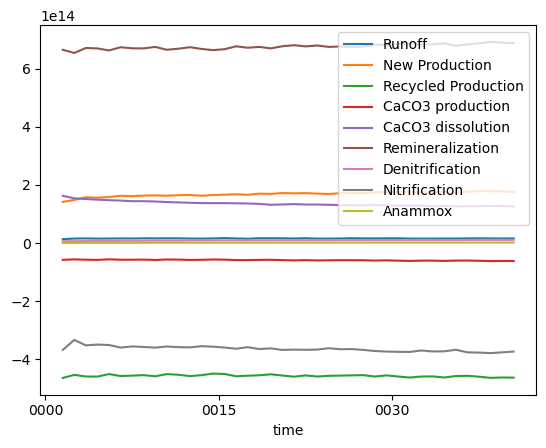

In [30]:
runoff.plot()
npp_no3.plot()
npp_nh4.plot()
prod_cadet.plot()
(diss_cadet + sed_diss_cadet).plot()
(remin + sed_remin).plot()
(denitrif + sed_denit).plot()
nitrif.plot()
amx.plot()
plt.legend(['Runoff', 'New Production', 'Recycled Production', 'CaCO3 production', 'CaCO3 dissolution', 'Remineralization', 'Denitrification', 'Nitrification', 'Anammox'])

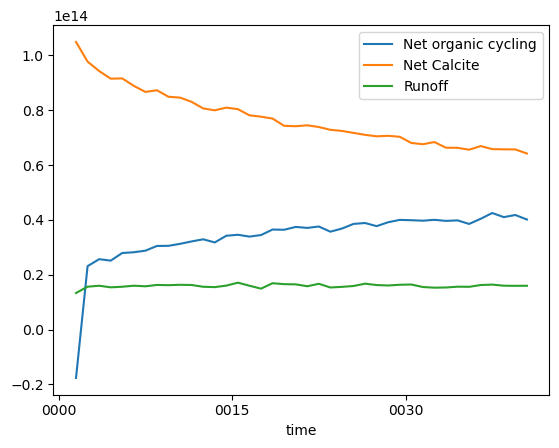

In [31]:
(npp_no3 + npp_nh4 + remin + sed_remin + denitrif + sed_denit + nitrif + amx).plot()
(diss_cadet + sed_diss_cadet + prod_cadet).plot()
runoff.plot()
plt.legend(['Net organic cycling','Net Calcite','Runoff'])

## Close budgets
The total carbon inventory should be equal to the starting inventory plus the carbon fluxes
In this case we start with year 2 and onwards, because the wc_vert_int_c term is saved at the end of year 1

Text(0.5, 1.0, 'Alkalinity fluxes as calculated by the change in the global alk inventory')

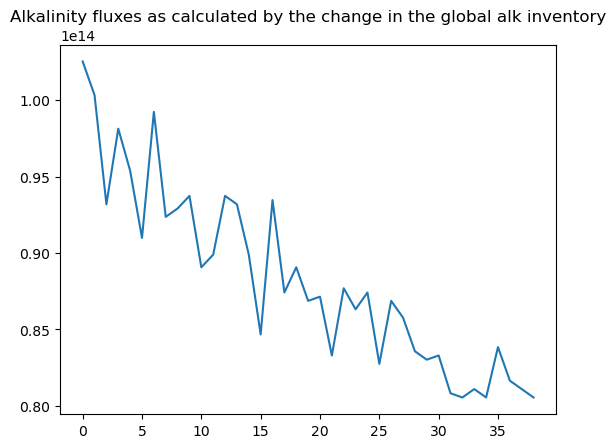

In [32]:
plt.plot(np.diff(global_total))
plt.title('Alkalinity fluxes as calculated by the change in the global alk inventory')

In [33]:
np.diff(global_total.values)

array([1.0252946e+14, 1.0033044e+14, 9.3183610e+13, 9.8131413e+13,
       9.5382634e+13, 9.0984587e+13, 9.9230924e+13, 9.2358977e+13,
       9.2908733e+13, 9.3733366e+13, 8.9060442e+13, 8.9885076e+13,
       9.3733366e+13, 9.3183610e+13, 8.9885076e+13, 8.4662395e+13,
       9.3458488e+13, 8.7411174e+13, 8.9060442e+13, 8.6861419e+13,
       8.7136297e+13, 8.3288006e+13, 8.7686052e+13, 8.6311663e+13,
       8.7411174e+13, 8.2738250e+13, 8.6861419e+13, 8.5761907e+13,
       8.3562884e+13, 8.3013128e+13, 8.3288006e+13, 8.0814105e+13,
       8.0539227e+13, 8.1088983e+13, 8.0539227e+13, 8.3837762e+13,
       8.1638738e+13, 8.1088983e+13, 8.0539227e+13], dtype=float32)

In [34]:
net_flux.values[1:]

array([1.36507973e+14, 1.35977047e+14, 1.32087179e+14, 1.35171814e+14,
       1.33096438e+14, 1.31251789e+14, 1.34074315e+14, 1.31654911e+14,
       1.32233748e+14, 1.31466571e+14, 1.29214162e+14, 1.27243162e+14,
       1.31218882e+14, 1.32082414e+14, 1.28063392e+14, 1.27066830e+14,
       1.30370756e+14, 1.27300463e+14, 1.28107102e+14, 1.27400328e+14,
       1.28166629e+14, 1.23920730e+14, 1.24888351e+14, 1.26184269e+14,
       1.26640043e+14, 1.24462280e+14, 1.25928405e+14, 1.26670380e+14,
       1.24403445e+14, 1.22842675e+14, 1.23712459e+14, 1.21326112e+14,
       1.21776255e+14, 1.19737369e+14, 1.23593010e+14, 1.24749508e+14,
       1.22773479e+14, 1.23460478e+14, 1.20349887e+14])

Text(0.5, 1.0, 'Global alkalinity inventory (Pg)')

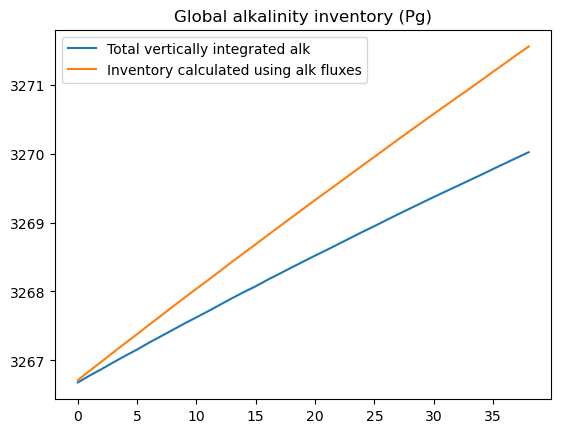

In [35]:
plt.plot(global_total.values[1:]/1e15)
plt.plot((np.cumsum(net_flux.values[1:])+global_total.values[0])/1e15)
plt.legend(['Total vertically integrated alk','Inventory calculated using alk fluxes'])
plt.title('Global alkalinity inventory (Pg)')

Text(0.5, 1.0, 'Total global alkalinity inventory imbalance')

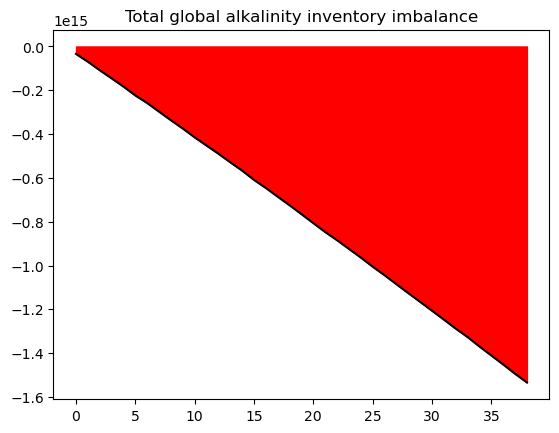

In [36]:
fig,ax = plt.subplots(1,1)
imbalance=(global_total.values[1:] - (np.cumsum(net_flux.values[1:])+global_total.values[0]))
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global alkalinity inventory imbalance')

Text(0.5, 1.0, 'Total global alkalinity budget imbalance')

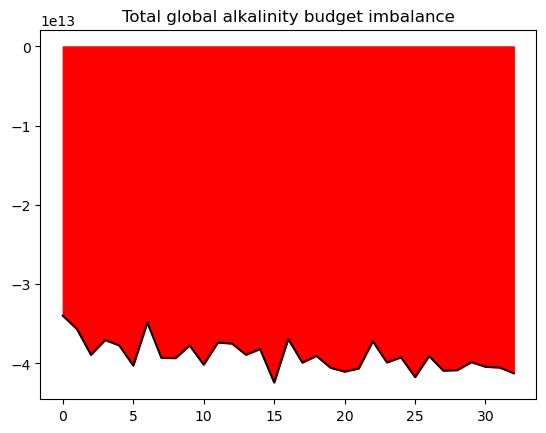

In [37]:
fig,ax = plt.subplots(1,1)
imbalance=(np.diff(global_total.values)[0:33] - net_flux.values[1:][0:33])
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global alkalinity budget imbalance')